In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Investigating the Relationship Between Wildfires and Air Quality in Yakima, Washington

This Jupyter Notebook is dedicated to exploring the link between wildfire occurrences in the vicinity of Yakima, Washington, and their potential influence on air quality. We aim to decipher the dynamics between these environmental elements through a data-driven approach.

To initiate our analysis, we will import the required libraries and load our data, which comprises information on both wildfires and air quality in JSON format. These datasets will be converted into pandas DataFrames to enable a detailed analysis.

Please note that the 'std_aqi.json' file can be obtained by executing the AQI Data Acquisition notebook, while the 'smoke_estimate_Yakima.json' file can be generated through the Wildfire Data Extraction notebook.

In [2]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt

In [3]:
smoke_df = pd.read_json('/content/drive/MyDrive/DATA_512_HW_3/smoke_estimate_Yakima.json')
smoke_df.head()

,OBJECTID,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Fire_Polygon_Tier,Fire_Attribute_Tiers,GIS_Acres,GIS_Hectares,Source_Datasets,Listed_Fire_Types,...,Prescribed_Burn_Notice,Wildfire_and_Rx_Flag,Overlap_Within_1_or_2_Flag,Circleness_Scale,Circle_Flag,Exclude_From_Summary_Rasters,Shape_Length,Shape_Area,distance,smoke_estimate
0,14299,14299,Wildfire,1963,1,"1 (1), 3 (3)",40992.458271,16589.059302,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (1), Likely Wildfire (3)",...,Prescribed fire data in this dataset represent...,None,None,0.385355,NaN,No,73550.428118,1.658906e+08,247.647882,331.054381
1,14300,14300,Wildfire,1963,1,"1 (1), 3 (3)",25757.090203,10423.524591,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (2), Likely Wildfire (2)",...,Prescribed fire data in this dataset represent...,None,None,0.364815,NaN,No,59920.576713,1.042352e+08,220.248108,233.891591
2,14301,14301,Wildfire,1963,1,"1 (5), 3 (15), 5 (1)",45527.210986,18424.208617,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (6), Likely Wildfire (15)",...,Prescribed fire data in this dataset represent...,None,None,0.320927,NaN,No,84936.827810,1.842421e+08,249.883106,364.388067
3,14302,14302,Wildfire,1963,1,"1 (1), 3 (3), 5 (1)",10395.010334,4206.711433,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (2), Likely Wildfire (3)",...,Prescribed fire data in this dataset represent...,None,None,0.428936,NaN,No,35105.903602,4.206711e+07,329.724046,63.052789
4,14303,14303,Wildfire,1963,1,"1 (1), 3 (3)",9983.605738,4040.221900,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (1), Likely Wildfire (3)",...,Prescribed fire data in this dataset represent...,None,None,0.703178,NaN,No,26870.456126,4.040222e+07,263.750993,75.704782


In [4]:
# Lets look at the mean, min and max of GIS_Acres which might help us in estimating the air quality
smoke_df.describe()

,OBJECTID,USGS_Assigned_ID,Fire_Year,Fire_Polygon_Tier,GIS_Acres,GIS_Hectares,Circleness_Scale,Circle_Flag,Shape_Length,Shape_Area,distance,smoke_estimate
count,75450.000000,75450.000000,75450.000000,75450.000000,7.545000e+04,75450.000000,75450.000000,6207.0,7.545000e+04,7.545000e+04,75450.000000,7.545000e+04
mean,70148.317376,70148.317376,2001.000888,2.855838,1.805048e+03,730.477100,0.480072,1.0,9.912223e+03,7.304771e+06,564.124967,1.089334e+01
std,36525.743889,36525.743889,14.751714,2.722102,1.346376e+04,5448.591144,0.259874,0.0,3.204042e+04,5.448591e+07,294.228062,1.170034e+02
min,14299.000000,14299.000000,1963.000000,1.000000,4.697010e-06,0.000002,0.000017,1.0,6.295036e-01,1.900813e-02,5.908581,3.227138e-08
25%,39014.250000,39014.250000,1990.000000,1.000000,1.585903e+01,6.417923,0.273963,1.0,1.273940e+03,6.417923e+04,306.699322,5.370704e-02
50%,64674.000000,64674.000000,2005.000000,1.000000,7.967309e+01,32.242556,0.446427,1.0,3.251582e+03,3.224256e+05,535.492317,2.901456e-01
75%,101857.000000,101857.000000,2013.000000,6.000000,4.949519e+02,200.299924,0.652273,1.0,8.811204e+03,2.002999e+06,797.529736,1.805565e+00
max,135061.000000,135061.000000,2020.000000,8.000000,1.032651e+06,417899.203637,0.997980,1.0,2.899586e+06,4.178992e+09,1249.896712,1.119745e+04


(array([   0., 1000., 2000., 3000., 4000., 5000., 6000., 7000.]),
 [Text(0, 0.0, '0'),
  Text(0, 1000.0, '1000'),
  Text(0, 2000.0, '2000'),
  Text(0, 3000.0, '3000'),
  Text(0, 4000.0, '4000'),
  Text(0, 5000.0, '5000'),
  Text(0, 6000.0, '6000'),
  Text(0, 7000.0, '7000')])

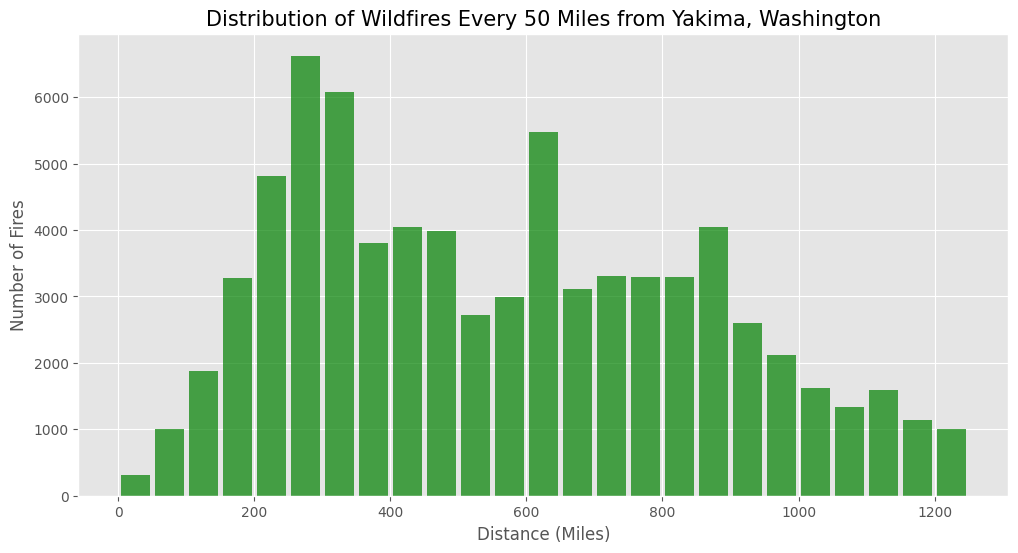

In [22]:
import matplotlib.pyplot as plt
import numpy as np

distances = []

for index, row in smoke_df.iterrows():
    distance_str = row['distance']
    distance_float = float(distance_str)
    distances.append(distance_float)

# Define the bins
bins = np.linspace(0, 1250, ((1250) // 50)+1)

# Set a style using plt.style.use() to make the plot look different
plt.style.use('ggplot')

# Create plot with a figure size to make it larger
plt.figure(figsize=(12, 6))

# Generate the histogram with a different color and transparency
n, bins, patches = plt.hist(distances, bins, color='green', alpha=0.7, rwidth=0.85)

# Customize the plot's aesthetics
plt.xlabel("Distance (Miles)", fontsize=12)
plt.ylabel("Number of Fires", fontsize=12)
plt.title("Distribution of Wildfires Every 50 Miles from Yakima, Washington", fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

In [7]:
area_burned = {}
for index, row in smoke_df.iterrows():
    year = row['Fire_Year']
    area = row['GIS_Acres']
    if year in area_burned:
        area_burned[year]+=area
    else:
        area_burned[year]=area

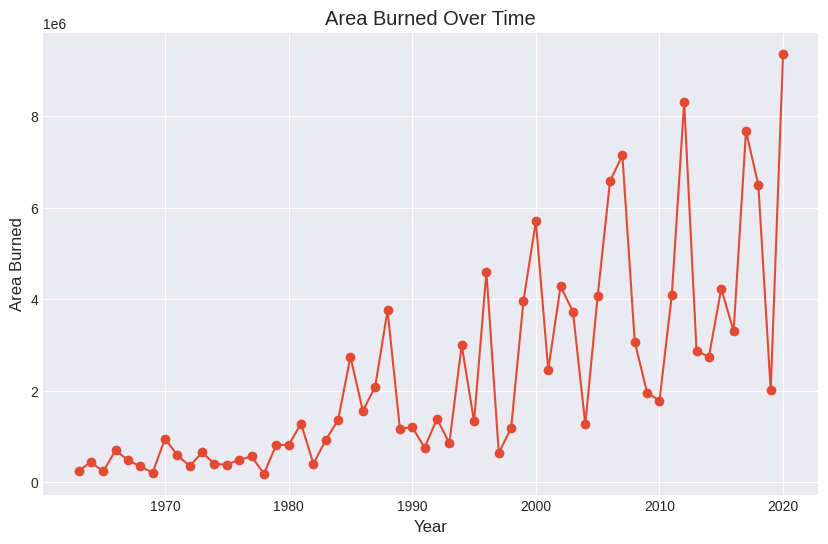

In [24]:
# Extract years and corresponding values
years = list(area_burned.keys())
values = list(area_burned.values())

# Create a time series plot
plt.figure(figsize=(10, 6))
plt.plot(years, values, marker='o', linestyle='-')
plt.title('Area Burned Over Time')
plt.xlabel('Year')
plt.ylabel('Area Burned')

# Show the plot
plt.show()

Estimating Fire Smoke

In [10]:
# We are only interested in the area burnt and the distance from the Redding.
# Based on these we will create a new dataframe having year wise estimated fire smoke.

smoke_df['es_aqi'] = (1 - smoke_df['distance'] / 1250) * (204 - smoke_df['GIS_Hectares'] / 204)
average_aqi_by_year = smoke_df.groupby('Fire_Year')['es_aqi'].mean()

In [11]:
std_aqi_data = pd.read_json('/content/drive/MyDrive/DATA_512_HW_3/std_aqi.json')

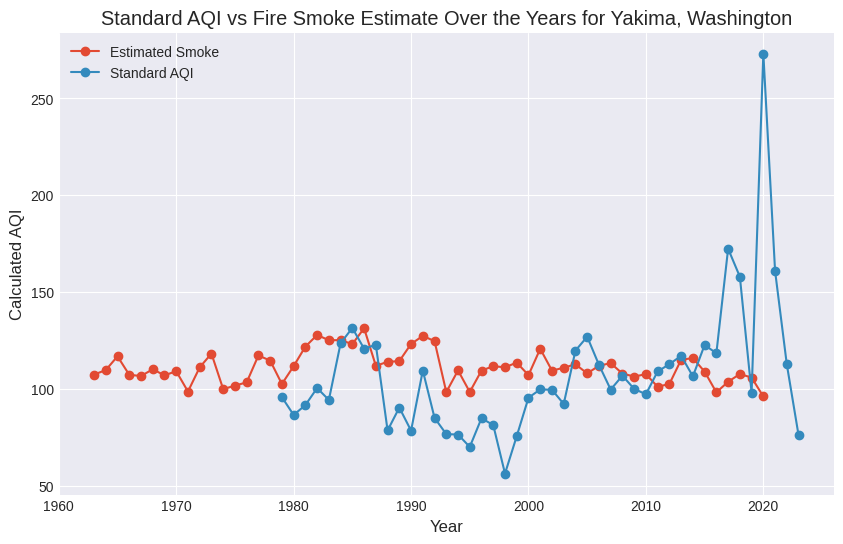

In [29]:
plt.figure(figsize=(10, 6))

plt.plot(average_aqi_by_year.index, average_aqi_by_year.values, label='Estimated Smoke', marker='o')

# Plot data from 1972
plt.plot(std_aqi_data['Year'], std_aqi_data['Calculated AQI'], label='Standard AQI', marker='o')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Calculated AQI')
plt.title('Standard AQI vs Fire Smoke Estimate Over the Years for Yakima, Washington')

# Add a legend to distinguish between the two datasets
plt.legend()

# Show the plot
plt.show()


Forecasting using Time Series Analysis

In [14]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.0 MB/s eta 0:00:00


In [16]:
from pmdarima import auto_arima
data = pd.Series(average_aqi_by_year)

model = auto_arima(data, seasonal=False, stepwise=True, suppress_warnings=True,
                   error_action="ignore", max_order=None, trace=True, information_criterion='bic')

best_order = model.get_params()['order']

print("Best (p, d, q) order:", best_order)

Performing stepwise search to minimize bic
 ARIMA(2,0,2)(0,0,0)[0]             : BIC=422.074, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=715.388, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=inf, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=648.222, Time=0.17 sec
 ARIMA(1,0,2)(0,0,0)[0]             : BIC=418.110, Time=0.24 sec
 ARIMA(0,0,2)(0,0,0)[0]             : BIC=600.273, Time=0.34 sec
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=416.621, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[0]             : BIC=418.177, Time=0.37 sec
 ARIMA(2,0,0)(0,0,0)[0]             : BIC=inf, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : BIC=410.193, Time=0.21 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : BIC=409.452, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=416.478, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : BIC=410.060, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : BIC=406.246, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : BIC=410.216, Time

In [18]:
!pip install statsmodels

In [19]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
model = ARIMA(data, order=(4, 2, 2))
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(steps=28)
predictions_data = pd.DataFrame({'Year': range(2021, 2049), 'Predictions': predictions})

print("AIC : "+str(model_fit.aic)+" BIC : "+str(model_fit.bic))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


AIC : 399.96939093450044 BIC : 414.1468527696465


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


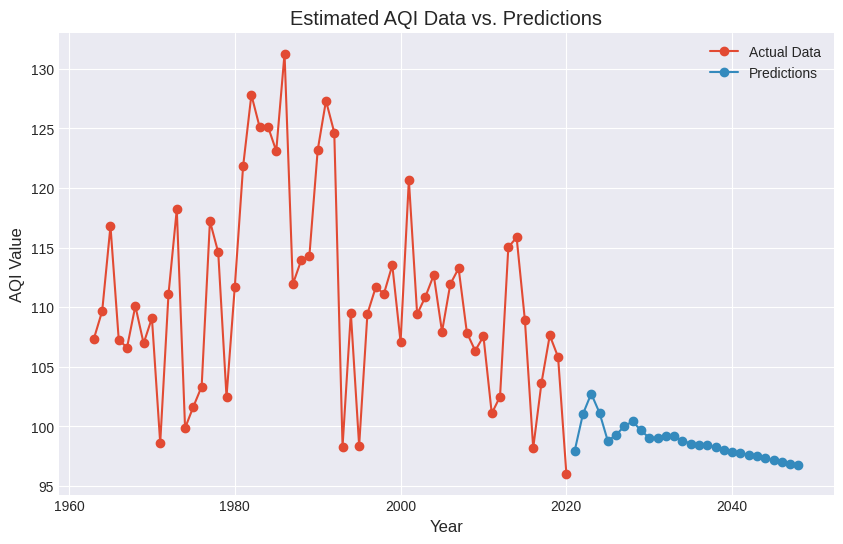

In [28]:
plt.figure(figsize=(10, 6))

# Plot the actual data
plt.plot(average_aqi_by_year.index, average_aqi_by_year.values, label='Actual Data', marker='o', markersize=6)

# # Plot the predictions
plt.plot(predictions_data['Year'], predictions_data['Predictions'], label='Predictions', marker='o', markersize=6)


# Set plot labels and legend
plt.xlabel('Year')
plt.ylabel('AQI Value')
plt.title('Estimated AQI Data vs. Predictions')
plt.legend()

# Show the plot
plt.show()